# <font color="blue">Load model and data</font>

In [1]:
import typing
import io
import os

import numpy as np
import torch
# import cv2
# import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

from models.modeling_VA import VisionTransformer, CONFIGS

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
import json

In [3]:
# %matplotlib notebook

%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [4]:
import matplotlib.patches as patches

In [6]:
# !pip install ml_collections

In [7]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [8]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model = model.eval()

In [9]:
backbone_cnn = model._modules['transformer'].embeddings

# <font color="blue">An example of mask in Pascal dataset</font>
Please download the data at [Pascal VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar)

Extract the dataset and save to **../../datasets**

Raw mask


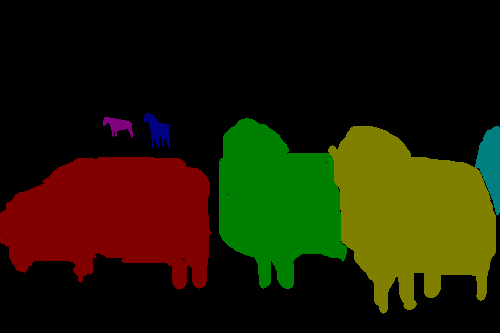

In [10]:
img = Image.open("../../datasets/VOCdevkit/VOC2009/SegmentationObject/2007_006944.png")
i_r = np.asarray(img)
i_r[i_r > 100] = 0
i_r = Image.fromarray(i_r).quantize(palette=img)
# i_r.save("ref.png")
print("Raw mask")
i_r

Mask after remove small object


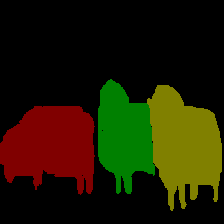

In [11]:
img = img.resize((224,224))
img_numpy = np.asarray(img).reshape(-1)
mask_selected = img_numpy.copy()
mask_selected[mask_selected > 100] = 0
num_object = len(np.unique(img_numpy))-2
for idx in range(num_object):
    idx_object = np.argwhere(img_numpy == idx+1).reshape(-1)
    if len(idx_object)<=0.14*0.14*224*224:
        mask_selected[idx_object] = 0
mask_selected = mask_selected.reshape([224,224])

ma = Image.fromarray(mask_selected).quantize(palette=img)
print("Mask after remove small object")
ma


Divide an mask into patches


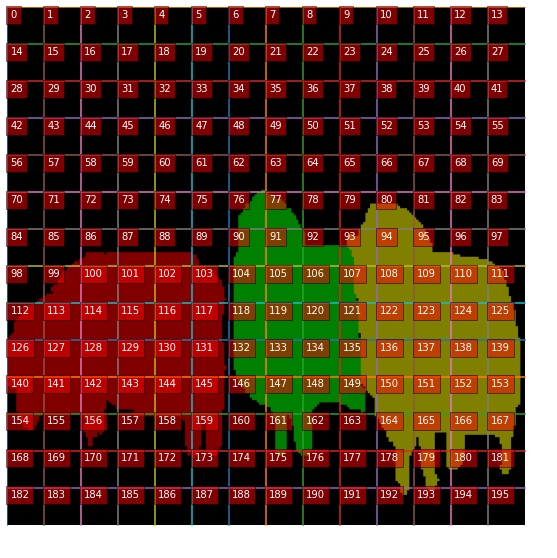

In [12]:
print("Divide an mask into patches")
plt.figure(figsize=(10, 10))
# img_sort = 2007_003189
ratio_size = 4
size_img = 224*ratio_size
plt.imshow(ma.resize((size_img,size_img)))
ax = plt.gca()
for i in range(14):
    ax.plot([i*16*ratio_size, i*16*ratio_size], [0, size_img])
    for j in range(14):
        if i == 0:
            ax.plot([0, size_img], [j*16*ratio_size, j*16*ratio_size])
        text_x, text_y = i*16*ratio_size+5, j*16*ratio_size+18
        ax.text(text_x, text_y, j*14+i, c='w', bbox=dict(facecolor='red', alpha=0.5), fontsize=10)
plt.axis('off')
plt.savefig('sample.png')
plt.show()


# <font color="blue">Loading Pascal dataset</font>

In [13]:
class VOC_dataset(Dataset):
    def __init__(self, img_dir, segment_dir, anno_dir, shuffle_grid=None, occlusion_mode=0, occlusion_ratio=1):
        
        self.img_dir = img_dir
        self.segment_dir = segment_dir
        self.anno_dir = anno_dir
        self.shuffle_grid = shuffle_grid
        self.occlusion_mode = occlusion_mode
        self.occlusion_ratio = occlusion_ratio
        # 0 -> none occlusion
        # 1 -> random occlude
        # 2 -> Salient occlusion
        # 3 -> non-salient occlusion
        
        self.max_num_object = 40
        
        img_name_lst = [name.split(".")[0] for name in os.listdir(img_dir)]
        seg_name_lst = [name.split(".")[0] for name in os.listdir(segment_dir)]
        anno_name_lst = [name.split(".")[0] for name in os.listdir(anno_dir)]
        
        self.img_name_lst = list(set(img_name_lst).intersection(seg_name_lst, anno_name_lst))
        
        print("Total number data", len(self.img_name_lst))
        
        self.transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ])
        self.trans_segment = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.img_name_lst)
    
    def _preprocess_im(self, im):
        transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        x = transform(im)
        return x, im

    def _shuffle_img(self, im, grid_size=14, mask_full=None):
        ids = np.arange(grid_size**2)
        np.random.shuffle(ids)
        im = np.array(im)
    #     print(im.shape)
        im_shuf = np.zeros_like(im)
        mask_shuf = np.zeros_like(mask_full)
        h, w = im.shape[:2]
        w_scale = w//grid_size
        h_scale = h//grid_size
        def _locate_xy(i):
            row_id = int(i//grid_size)
            col_id = i%grid_size
            row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
            col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
            return [row_star, row_end, col_star, col_end]
        for i_target, i_org in enumerate(ids):
            row_star, row_end, col_star, col_end = _locate_xy(i_org)
            row_tar_star, row_tar_end, col_tar_star, col_tar_end = _locate_xy(i_target)

            patch = im[row_star:row_end, col_star:col_end, :].copy()
    #         print(row_star,row_end, col_star,col_end, patch.shape)
            im_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end, :] = patch

            patch_mask = mask_full[row_star:row_end, col_star:col_end].copy()
    #         print(row_star,row_end, col_star,col_end, patch_mask.shape)
            mask_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end] = patch_mask
        im_shuf = Image.fromarray(im_shuf)
        x_shuf, im_shuf = self._preprocess_im(im_shuf)
        return x_shuf, im_shuf, mask_shuf
    
    def _occlude(self, im, mask, grid_size=14, n_random_ocl=None,
                 is_random=False, is_salient=False, is_non_salient=False):
        ids = np.arange(grid_size**2)
        im_cp = np.array(im)
        mask_cp = np.array(mask)
        mask_all = mask_cp.copy()
        mask_all[mask_all > 200] = 0  # remove uncertain area
        mask_all[mask_all!= 0] = 1  # make all object patch is the same object

        h, w = np.array(im).shape[:2]
        w_scale = w//grid_size
        h_scale = h//grid_size

        object_patch = []
        non_object_patch = []
        for i in range(grid_size):
            for j in range(grid_size):
    #             print(i, j, i*grid_size + j, mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean())
                if mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean() > 0.15:
                    object_patch.append(i*grid_size + j)
                else:
                    non_object_patch.append(i*grid_size + j)
        if is_salient:
            num_occ = int(n_random_ocl*len(object_patch))
            np.random.shuffle(object_patch)
            id_patches = object_patch[:num_occ]
        elif is_non_salient:
            num_occ = int(n_random_ocl*len(non_object_patch))
            np.random.shuffle(non_object_patch)
            id_patches = non_object_patch[:num_occ]
        elif is_random:
            id_patches = np.arange(grid_size*grid_size)
            np.random.shuffle(id_patches)
            n_random_ocl = int(len(id_patches)*n_random_ocl)      
            id_patches = id_patches[:n_random_ocl]
        else:
            id_patches = []

        def _locate_xy(i):
            row_id = int(i//grid_size)
            col_id = i%grid_size
            row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
            col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
            return [row_star, row_end, col_star, col_end]

        for i in id_patches:
            row_star, row_end, col_star, col_end = _locate_xy(i)
            im_cp[row_star:row_end, col_star:col_end, :] = 0
            mask_cp[row_star:row_end, col_star:col_end] = 0
        return im_cp, mask_cp

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

        raw_img_name = self.img_name_lst[idx]
#         print("\t", raw_img_name)
        
        anno_link = os.path.join(self.anno_dir, "{}.xml".format(raw_img_name))
        tree = ET.parse(anno_link)
        root = tree.getroot()
        lbs = []
        for item in root.findall('./object'):
            for child in item:
                if child.tag == "name":
                    lbs.append(child.text)

        img_path = os.path.join(self.img_dir, "{}.jpg".format(raw_img_name))
        image = Image.open(img_path)
        image = image.resize((224,224))
        
        segmentation_link = os.path.join(self.segment_dir, "{}.png".format(raw_img_name))
        seg_img = Image.open(segmentation_link)
        seg_img = seg_img.resize((224,224))
        seg_img = np.asarray(seg_img)
        
        if self.shuffle_grid:
            image = image.resize((224,224))
            img_trans, img_shuf, seg_shuf = self._shuffle_img(image, grid_size=self.shuffle_grid, mask_full=seg_img)
            seg_img = seg_shuf
        elif self.occlusion_mode == 1:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_random=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        elif self.occlusion_mode == 2:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_salient=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        elif self.occlusion_mode == 3:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_non_salient=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        else:
            img_trans = self.transformer(image)

            
        return img_trans, seg_img , lbs

In [14]:
dataset_val = VOC_dataset(img_dir="../../datasets/VOCdevkit/VOC2009/JPEGImages",
                          segment_dir="../../datasets/VOCdevkit/VOC2009/SegmentationObject",
                          anno_dir="../../datasets/VOCdevkit/VOC2009/Annotations",
#                          shuffle_grid=None)  # if not shuffle data
#                          shuffle_grid=2,  # if  shuffle data with grid size 2
#                          occlusion_mode=3, occlusion_ratio=1.0   # if using image occlusion
                         )
data_voc = DataLoader(dataset_val, 1, pin_memory=True, shuffle=True)

Total number data 1499


# <font color="blue">Get result of ViT</font>

In [15]:
idx_run_data = -1
log = False
num_vlid_data = 0

stats_logits = []
stats_img = []
stats_att_mat = []
stats_hidden_states = []
stats_valid_bb = []
stats_valid_mask = []
stats_valid_labels = []

for img_trans, seg_trans, labels in data_voc:
    idx_run_data += 1
    is_valid_result = True
    bb_keep = []
    label_keep = []
    mask_keep = []
    labels = np.asarray(labels).reshape(-1)

    seg_trans = seg_trans[0].detach().numpy().reshape(-1)
    seg_trans[seg_trans > 200] = 0
    num_object = len(labels)
    if num_object >= 2:
        for idx_object in range(num_object):
            idx_object_token = np.argwhere(seg_trans==idx_object+1).reshape(-1)
            if len(idx_object_token) > 0.14*224*0.14*224:
                mask_object = np.zeros_like(seg_trans).reshape(-1)
                mask_object[idx_object_token] = 1
                mask_keep.append(mask_object)
                label_keep.append(labels[idx_object])
    if len(mask_keep) < 2:
        is_valid_result = False
    if is_valid_result:
        logits, att_mat, hidden_states_layers  = model(img_trans)
        probs = torch.nn.Softmax(dim=-1)(logits)
        top5 = torch.argsort(probs, dim=-1, descending=True)
        if is_valid_result and len(mask_keep) >= 2:
            
            num_vlid_data += 1
            att_mat = torch.stack(att_mat).squeeze(1)
            att_mat = torch.mean(att_mat, dim=1) # [n_layer, n_tokens, n_tokens]=[12, 197, 197]
            # To account for residual connections, we add an identity matrix to the
            # attention matrix and re-normalize the weights.
            residual_att = torch.eye(att_mat.size(1)) # [n_tokens, n_tokens]=[197, 197]
            aug_att_mat = att_mat + residual_att
            aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

            stats_logits.append(logits[0])
            stats_att_mat.append(aug_att_mat)
            stats_hidden_states.append(torch.stack(hidden_states_layers).squeeze(1))
            stats_valid_mask.append(np.stack(mask_keep))
            stats_valid_labels.append(label_keep)
            
            if num_vlid_data < 10:
                stats_img.append(img_trans)
    if idx_run_data % 100 == 0:
        print("idx_run_data:", idx_run_data, "num_vlid_data:", num_vlid_data)
    if idx_run_data > 1000:
        break
print("idx_run_data:", idx_run_data, "num_vlid_data:", num_vlid_data)

idx_run_data: 0 num_vlid_data: 0
idx_run_data: 100 num_vlid_data: 36
idx_run_data: 200 num_vlid_data: 74
idx_run_data: 300 num_vlid_data: 113
idx_run_data: 400 num_vlid_data: 147
idx_run_data: 500 num_vlid_data: 185
idx_run_data: 600 num_vlid_data: 225
idx_run_data: 700 num_vlid_data: 262
idx_run_data: 800 num_vlid_data: 294
idx_run_data: 900 num_vlid_data: 328
idx_run_data: 1000 num_vlid_data: 366
idx_run_data: 1001 num_vlid_data: 367


In [16]:
stats_hidden_states = torch.stack(stats_hidden_states)
print(stats_hidden_states.size())

stats_att_mat = torch.stack(stats_att_mat)
print(stats_att_mat.size())

torch.Size([367, 12, 197, 768])
torch.Size([367, 12, 197, 197])


# <font color="blue">Cluster embeddings and calculate the measurements</font>

In [17]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.optimize import linear_sum_assignment

In [18]:
print("Maximum number of objects in an image", max([len(l) for l in stats_valid_labels]))

Maximum number of objects in an image 7


In [19]:
stats_pur_matrix = []
stats_token_in_cluster = []
stats_intracluster = []

stats_rate_uniq_label = []
stats_rate_clus_object = []
stats_silhouette = []


for idx_sample, (hidden_all_layers, mask_all_objects, gt_label) in enumerate(zip(stats_hidden_states, stats_valid_mask, stats_valid_labels)):
    is_invalid_sample = False
    db_scan_cls_labels = []
    rate_uniq_label_layers = []
    rate_clus_object = []
    score_silhouette = []
    mask_to_idx = []
    
    total_mask = []
    gt_label = gt_label
    for idx_object, m in enumerate(mask_all_objects):
        m = m.astype(np.float64).reshape((224,224))
        m_instance = np.zeros((14, 14), dtype=np.float64)
        for i in range(14):
            for j in range(14):
                m_instance[i, j] = m[i*16: (i+1) * 16, j*16: (j+1) * 16].mean()+0.6

        total_mask.append(m_instance.astype(np.int32) * (idx_object + 1))

    total_mask = np.stack(total_mask).sum(0).reshape(-1)
    mask_to_idx = []
    for idx_object in range(len(mask_all_objects)):
        object_idx = np.argwhere(total_mask == idx_object+1).reshape(-1)
        if len(object_idx) <= 2:
            is_invalid_sample = True
        mask_to_idx.append(object_idx)
    none_object_idx = np.argwhere(1-m_instance).reshape(-1)
    all_object_idx = np.concatenate(mask_to_idx)
    
    num_object = len(mask_to_idx)
    pur_matrix_layer = []
    token_in_cluster_layer = []
    intra_layer = []
    if is_invalid_sample:
        continue
    for lvl, hidden_layer_i in enumerate(hidden_all_layers):
        # ignore the cls_token
        hidden_layer_i = hidden_layer_i.detach().numpy()
        dis_eps = []
        len_token = []
        for idx_token_object in mask_to_idx:
            len_token.append(len(idx_token_object))
            dis_eps_obj = (hidden_layer_i[1:][idx_token_object[:-1]] - hidden_layer_i[1:][idx_token_object[1:]])**2
            dis_eps_obj = np.sqrt(dis_eps_obj.sum(-1)).mean()
            dis_eps.append(dis_eps_obj)
        dis_eps = sum(dis_eps)/len(mask_to_idx)
        mean_token = min(len_token)
        db = DBSCAN(eps=dis_eps, min_samples=3).fit(hidden_layer_i[1:][all_object_idx])  # => better => max=0.7
        db_scan_cls_labels.append(db.labels_)
        db_label = np.ones(len(hidden_layer_i[1:]), dtype=int)*-10
        db_label[all_object_idx] = db.labels_
        num_cluster = max(db_label) + 1
        pur_matrix = np.zeros((num_cluster, num_object))
#         print(num_cluster)
        token_in_cluster = []
        intra_cluster = []
        sum_pur = 0
        rate_clus_object.append(num_cluster/num_object)
        dominated_label_cluster = []
        for idx_clus in range(num_cluster):
            idx_in_clus = np.argwhere(db_label == idx_clus).reshape(-1)
#             print(idx_in_clus)
            max_pur = -1
            token_max_pur = None
            dominate_label = -1
            for idx_obj in range(num_object):
                idx_object_token = mask_to_idx[idx_obj]
                inter_index = set(idx_in_clus).intersection(idx_object_token)
                purity = len(inter_index)/len(idx_in_clus)
                pur_matrix[idx_clus, idx_obj] = purity
                if purity > max_pur:
                    max_pur = purity
                    dominate_label = gt_label[idx_obj]
                    token_max_pur = hidden_layer_i[1:][idx_in_clus]
            sum_pur += pur_matrix[idx_clus].max()*(len(idx_in_clus)/sum(len_token))
            dominated_label_cluster.append(dominate_label)
            if len(token_max_pur):
                dis_pairwise = cosine_similarity(token_max_pur)
                iu1 = np.triu_indices(len(token_max_pur), 1)
                intra_cluster.append(dis_pairwise[iu1].mean())
        dominated_label_cluster_rate = len(np.unique(dominated_label_cluster))/len(np.unique(gt_label))
        rate_uniq_label_layers.append(dominated_label_cluster_rate)
        pur_matrix_layer.append(sum_pur)
        if len(intra_cluster) > 0:
            intra_layer.append(sum(intra_cluster)/len(intra_cluster))
        else:
            intra_layer.append(-1)
        if num_cluster == 0:
            score_silhouette.append(-1)
        elif num_cluster == 1:
            score_silhouette.append(0)
        else:
            sample_in_cls = []
            cls_label = []
            for idx_clus in range(num_cluster):
                idx_in_clus = np.argwhere(db_label == idx_clus).reshape(-1)
                sample_in_cls.append(hidden_layer_i[1:][idx_in_clus])
                cls_label.append([idx_clus]*len(idx_in_clus))
            sample_in_cls = np.concatenate(sample_in_cls)
            
            cls_label = np.concatenate(cls_label)
            sc = silhouette_score(sample_in_cls, cls_label, metric='cosine')
            score_silhouette.append(sc)
    stats_pur_matrix.append(pur_matrix_layer)
    stats_intracluster.append(intra_layer)
    stats_rate_uniq_label.append(rate_uniq_label_layers)
    stats_rate_clus_object.append(rate_clus_object)
    stats_silhouette.append(score_silhouette)
    if len(stats_pur_matrix) == 500:
        break

In [21]:
stats_silhouette = np.asarray(stats_silhouette)
print(stats_silhouette.shape)
stats_pur_matrix = np.asarray(stats_pur_matrix)
print(stats_pur_matrix.shape)
stats_rate_clus_object = np.asarray(stats_rate_clus_object)
print(stats_rate_clus_object.shape)
stats_rate_uniq_label = np.asarray(stats_rate_uniq_label)
print(stats_rate_uniq_label.shape)
stats_intracluster = np.asarray(stats_intracluster)
print(stats_intracluster.shape)

(361, 12)
(361, 12)
(361, 12)
(361, 12)
(361, 12)


In [22]:
cosine_distance_layer = []
for idx_sample, (hidden_all_layers, mask_all_objects) in enumerate(zip(stats_hidden_states, stats_valid_mask)):
    mask_to_idx = []
    is_invalid_sample = False
    total_mask = []
    for idx_object, m in enumerate(mask_all_objects):
        m = m.astype(np.float64).reshape((224,224))
        m_instance = np.zeros((14, 14), dtype=np.float64)
        for i in range(14):
            for j in range(14):
                m_instance[i, j] = m[i*16: (i+1) * 16, j*16: (j+1) * 16].mean()+0.6

        total_mask.append(m_instance.astype(np.int32) * (idx_object + 1))
    total_mask = np.stack(total_mask).sum(0).reshape(-1)
#     print(total_mask)
    mask_to_idx = []
    for idx_object in range(len(mask_all_objects)):
        object_idx = np.argwhere(total_mask == idx_object+1).reshape(-1)
        if len(object_idx) <= 2:
            is_invalid_sample = True
        mask_to_idx.append(object_idx)
    none_object_idx = np.argwhere(total_mask == 0).reshape(-1)
    all_object_idx = np.concatenate(mask_to_idx)
    
    num_object = len(mask_to_idx)
    pur_matrix_layer = []
    token_in_cluster_layer = []
    intra_layer = []
    if is_invalid_sample:
        continue
    
    cosine_dis_lvl = []
    for hidden_lvl in hidden_all_layers:
        hidden_lvl = hidden_lvl[1:].detach().numpy()
        cosine_mean_object = 0
        for idx_token_object in mask_to_idx:
            token_obj = hidden_lvl[idx_token_object]
            cosine_dis = cosine_similarity(token_obj)
            idx_triu = np.triu_indices(len(token_obj), 1)
            cosine_mean_object += cosine_dis[idx_triu].mean()
        cosine_mean_object = cosine_mean_object/len(mask_all_objects)
        cosine_dis_lvl.append(cosine_mean_object)
    cosine_distance_layer.append(cosine_dis_lvl)

In [23]:
cosine_distance_layer = np.asarray(cosine_distance_layer)
print(cosine_distance_layer.shape)

(361, 12)


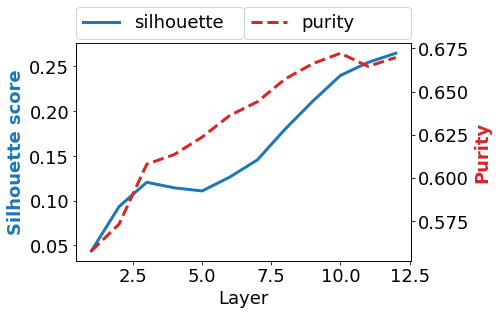

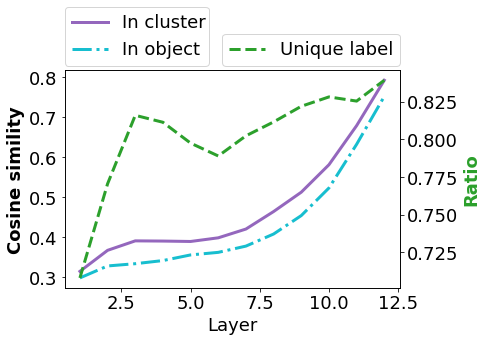

In [24]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=18)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_silhouette.mean(0), label="silhouette", color='tab:blue', linewidth=3)
ax2.plot(np.arange(1, 13), stats_pur_matrix.mean(0), label="purity", color='tab:red', linewidth=3, linestyle="dashed")

ax1.legend(bbox_to_anchor=(0., 1.02, 0.5, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.5, 1.02, 0.5, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Silhouette score', color='tab:blue', fontsize=18, fontweight='bold')
ax2.set_ylabel('Purity', color='tab:red', fontsize=18, fontweight='bold')

# plt.savefig("sil_pur_rate.png", bbox_inches='tight', pad_inches=0)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_intracluster.mean(0), label="In cluster", color='tab:purple', linewidth=3)
ax1.plot(np.arange(1, 13), cosine_distance_layer.mean(0), label="In object", color='tab:cyan', linewidth=3, linestyle="dashdot")
ax2.plot(np.arange(1, 13), stats_rate_uniq_label.mean(0), label="Unique label", color='tab:green', linewidth=3, linestyle="dashed")

ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Cosine simility', color='k', fontsize=18, fontweight='bold')
ax2.set_ylabel('Ratio', color='tab:green', fontsize=18, fontweight='bold')
ax1.legend(bbox_to_anchor=(0., 1.02, 0.43, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.47, 1.02, 0.53, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# plt.savefig("cosine_uniq_rate.png", bbox_inches='tight', pad_inches=0)
plt.show()

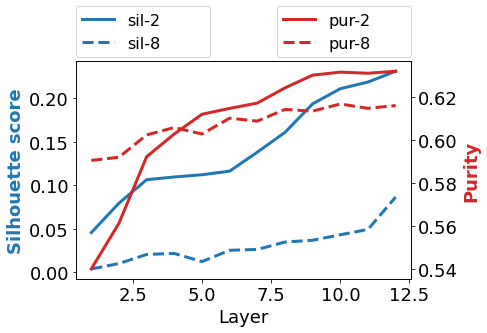

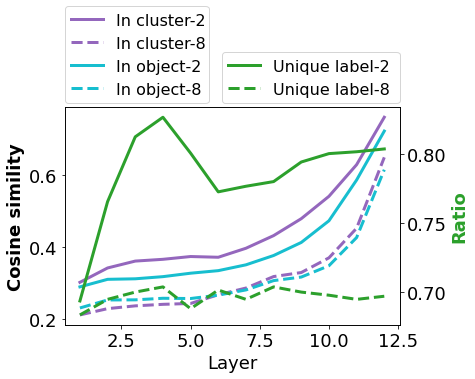

In [209]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=16)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_silhouette_2.mean(0), label="sil-2", color='tab:blue', linewidth=3)
ax1.plot(np.arange(1, 13), stats_silhouette_8.mean(0), label="sil-8", color='tab:blue', linewidth=3, linestyle="dashed")
ax2.plot(np.arange(1, 13), stats_pur_matrix_2.mean(0), label="pur-2", color='tab:red', linewidth=3)
ax2.plot(np.arange(1, 13), stats_pur_matrix_8.mean(0), label="pur-8", color='tab:red', linewidth=3, linestyle="dashed")

ax1.legend(bbox_to_anchor=(0., 1.02, 0.4, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.6, 1.02, 0.4, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Silhouette score', color='tab:blue', fontsize=18, fontweight='bold')
ax2.set_ylabel('Purity', color='tab:red', fontsize=18, fontweight='bold')
# ax1.set(xlim=(1, 13))
# ax2.set(xlim=(1, 13))
plt.savefig("sil_pur_rate_28.png", bbox_inches='tight', pad_inches=0)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_intracluster_2.mean(0), label="In cluster-2", color='tab:purple', linewidth=3)
ax1.plot(np.arange(1, 13), stats_intracluster_8.mean(0), label="In cluster-8", color='tab:purple', linewidth=3, linestyle="dashed")
ax1.plot(np.arange(1, 13), cosine_distance_layer_2.mean(0), label="In object-2", color='tab:cyan', linewidth=3)
ax1.plot(np.arange(1, 13), cosine_distance_layer_8.mean(0), label="In object-8", color='tab:cyan', linewidth=3, linestyle="dashed")
ax2.plot(np.arange(1, 13), stats_rate_uniq_label_2.mean(0), label="Unique label-2", color='tab:green', linewidth=3)
ax2.plot(np.arange(1, 13), stats_rate_uniq_label_8.mean(0), label="Unique label-8", color='tab:green', linewidth=3, linestyle="dashed")

ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Cosine simility', color='k', fontsize=18, fontweight='bold')
ax2.set_ylabel('Ratio', color='tab:green', fontsize=18, fontweight='bold')
# bbox_to_anchor=(0., 1.02, 3.5, .102), loc='lower left',
#                       ncol=6, mode="expand", borderaxespad=0., prop={"size":16}
ax1.legend(bbox_to_anchor=(0., 1.02, 0.43, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# ax1.set(xlim=(1, 13))
# ax1.legend()
ax2.legend(bbox_to_anchor=(0.47, 1.02, 0.53, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# ax2.set(xlim=(1, 13))
plt.savefig("cosine_uniq_rate_28.png", bbox_inches='tight', pad_inches=0)

plt.show()

# <font color="blue">Process individual image</font>

In [25]:
# img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
# img_url = 'http://www.sydneyolympicpark.com.au/-/media/images/sopa/sydney-olympic-park-site/the-park/community/dogsinthepark-header-image.jpg'
# img_url = 'https://media.jlrms.com/styles/low_res/s3/alf/images/2019-06/14681b51-bc4b-4cff-8168-417d58cc7b52/jagxe300sportsvproject8dna18101806.jpg' # couple car
# img_url = 'https://www.popsci.com/uploads/2020/09/24/BIII6V75B5HJXJEFITGMI5GWAM-1024x768.jpg' # elephant
# img_url = 'https://res.cloudinary.com/jerrick/image/upload/f_jpg,fl_progressive,q_auto,w_1024/609c031f84017b001f224989.jpg'
# img_url = 'https://www.caninecompany.com/getmedia/eb5aa50d-253a-4f69-805f-6dced4349046/splash-1.jpg' # single white dog

# dog_cat
img_url = 'https://i.insider.com/536aa78069bedddb13c60c3a?width=600&format=jpeg&auto=webp'
# 2 elephant
# img_url = 'https://mysteriousofscience.com/wp-content/uploads/2021/06/b-4-590x295.jpg'

#dog and bird big
# img_url = 'https://i.ytimg.com/vi/OBkjD2iAQ6Q/maxresdefault.jpg' # dog bird

# multiple objects
# img_url = [
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02277742_ringlet.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01582220_magpie.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02403003_ox.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02749479_assault_rifle.JPEG?raw=true'
# ]

def _preprocess(url):
#   urlretrieve(img_url, "/content/gdriver/MyDrive/ViT_data/attention_data/img.jpg")
    mix = False
    if isinstance(url, list):
        mix = True
    if mix:
        for idx_img, img_link in enumerate(url):
            urlretrieve(img_link, "attention_data/img_{}.jpg".format(idx_img))
    else:
        urlretrieve(url, "attention_data/img.jpg")
    
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    if mix:
        img_numpy = []
        for idx_img, img_link in enumerate(url):
            img_np = np.asarray(Image.open("attention_data/img_{}.jpg".format(idx_img)).resize((224, 224)))
            if img_np.ndim == 2:
                img_np = np.tile(img_np[..., None], [1,1,3])
            img_numpy.append(img_np)
        img_numpy = np.stack(img_numpy)
        img_numpy = img_numpy.reshape([2, 2, 224, 224, 3]).transpose([0, 2, 1, 3, 4])  # [2, 224, 2, 224, 3]
        img_numpy = img_numpy.reshape([2*224, 2*224, 3])
        im = Image.fromarray(img_numpy)
    else:
        im = Image.open("attention_data/img.jpg")
    #   im = Image.open("/content/gdriver/MyDrive/paper_transformer_visualization_VA/ViT-pytorch/attention_data/cat_dog.jpg")
    x = transform(im)
    im = im.resize((224,224))
    return x, im
#     return img_numpy

x, im = _preprocess(img_url)

torch.Size([3, 224, 224])


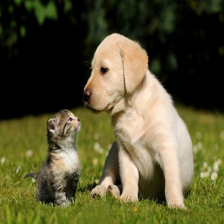

In [26]:
im

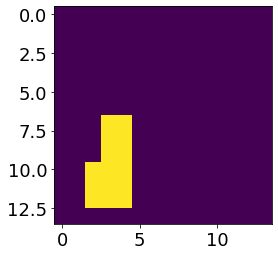

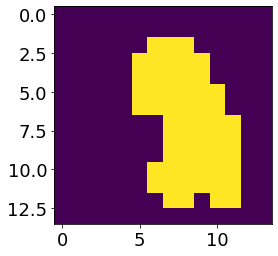

In [27]:
 # dog cat
mask_tempo = [
    [101,102,115,116,129,130,142,144,156,158,170,172],
    [34, 36, 47, 51, 61, 65, 75, 80, 89, 94, 105, 109, 119, 123, 133, 137, 146, 151, 160, 165, 175, 176, 178, 179]
]

#2 elephant
# mask_tempo = [
#     [3,4,6,7,17,21,31,35,44,49,58,63,72, 77, 86, 89,100,103, 114, 117, 128,132, 142, 146, 156,156, 158, 160, 170, 170, 172, 174, 184, 184, 186, 188],
#     [122, 122, 135, 137,149,151,163,165,177,179, 191, 192]
# ]

#dog and bird big
# mask_tempo = [
# #     [30, 31, 43, 45, 58, 59, 72, 77, 86, 93, 100, 110,115, 122, 130, 134, 145, 146,186,187],
#     [30, 31, 43, 45, 58, 59, 72, 77, 86, 93, 100, 110,115, 125, 130, 134, 145, 146, 159, 160, 173, 174, 186,187]
# ]

# multiple objects
# mask_tempo = [
#     [29, 32, 43, 47, 58, 61, 72, 74],
#     [38, 38, 52, 52],
#     [50, 50, 64, 64, 78, 78],
#     [102,104,115, 118, 129, 132, 142, 146, 156, 160, 170, 174, 185, 188],
#     [133, 134, 147, 152, 161,163]
# ]  # -> mix of 4 image with 5 object

mask_keep = []
for m_instance in mask_tempo:
    x_st = None
    x_end = None
    real_mask = []
    _m = np.zeros((14, 14), dtype=np.uint8)
    for idx, idx_path in enumerate(m_instance):
        if idx % 2 == 0:
            x_st = idx_path
        else:
            x_end = idx_path
        if x_st is not None and x_end is not None:
            real_mask.append(np.arange(x_st, x_end+1))
            x_st = None
            x_end = None
    real_mask = torch.tensor(np.concatenate(real_mask))
    _m = _m.reshape(-1)
    _m[real_mask] = 255
    
    _m = _m.reshape((14, 14))
    plt.figure()
    plt.imshow(_m)
    plt.show()
    mask_keep.append(real_mask)

mask_to_idx = []
for m_instance in mask_keep:
    m_instance = m_instance.reshape(-1).type(torch.long).detach().numpy()
    mask_to_idx.append(m_instance)

total_mask = np.concatenate(mask_to_idx).reshape(-1)

none_object_idx = []
for i in range(14*14):
    if i not in total_mask:
        none_object_idx.append(i)
none_object_idx = np.asarray(none_object_idx)
mask_to_idx.append(none_object_idx)

In [28]:
mask_keep = []
mask_full_keep = []
for idx_object, m_instance in enumerate(mask_tempo):
    mask_full = np.zeros((224, 224), dtype=np.uint8)
    x_st = None
    x_end = None
    real_mask = []
    _m = np.zeros((14, 14), dtype=np.uint8)
    for idx, idx_path in enumerate(m_instance):
        if idx % 2 == 0:
            x_st = idx_path
        else:
            x_end = idx_path
        if x_st is not None and x_end is not None:
            i_min = x_st//14
            j_min = x_st - i_min*14
            i_max = x_end//14
            j_max = x_end - i_max*14
#             print(i_min, j_min, i_max, j_max)
            i_full_mix = i_min*16
            j_full_min = j_min*16
            i_full_max = (i_max+1)*16
            j_full_max = (j_max+1)*16
            
            mask_full[i_full_mix:i_full_max, j_full_min:j_full_max] = idx_object+1
#             mask_full[i_full_mix:i_full_max, j_full_min:j_full_max] = 1
            
            real_mask.append(np.arange(x_st, x_end+1))
            x_st = None
            x_end = None
#     plt.figure()
#     plt.imshow(mask_full[..., None]*im)
#     plt.show()
    mask_full_keep.append(mask_full)
mask_full_keep = np.stack(mask_full_keep).sum(0)
mask_full_keep.shape

(224, 224)

In [29]:
def _preprocess_im(im):
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    x = transform(im)
    return x, im

def _shuffle_img(im, grid_size=14, mask_full=None):
    ids = np.arange(grid_size**2)
    np.random.shuffle(ids)
    im = np.array(im)
#     print(im.shape)
    im_shuf = np.zeros_like(im)
    mask_shuf = np.zeros_like(mask_full_keep)
    h, w = im.shape[:2]
    w_scale = w//grid_size
    h_scale = h//grid_size
    def _locate_xy(i):
        row_id = int(i//grid_size)
        col_id = i%grid_size
        row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
        col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
        return [row_star, row_end, col_star, col_end]
    for i_target, i_org in enumerate(ids):
        row_star, row_end, col_star, col_end = _locate_xy(i_org)
        row_tar_star, row_tar_end, col_tar_star, col_tar_end = _locate_xy(i_target)
        
        patch = im[row_star:row_end, col_star:col_end, :].copy()
#         print(row_star,row_end, col_star,col_end, patch.shape)
        im_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end, :] = patch
        
        patch_mask = mask_full_keep[row_star:row_end, col_star:col_end].copy()
#         print(row_star,row_end, col_star,col_end, patch_mask.shape)
        mask_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end] = patch_mask
    im_shuf = Image.fromarray(im_shuf)
    x_shuf, im_shuf = _preprocess_im(im_shuf)
    return x_shuf, im_shuf, mask_shuf

In [30]:
def _occlude(im, mask, grid_size=14, n_random_ocl=None,
                 is_random=False, is_salient=False, is_non_salient=False):
    ''' This function create occlusion image based on input image. 
    we can create random occlusion if exist n_random_ocl.
    in other hand, return a salient or non-salient object based on the id patches of occlusion position.
    Args:
    im: -> PIL.Image; the input image
    grid_size: ->  dtype int; number of patches is seperated.
    id_patches: -> dtype list; a list of occlusion id patches. The ids are arranged from left to right and top to buttom within range [0, 195].
    n_random_ocl: -> dtype int or float; in case of integer dtype, it is number of patches is randomly selected to be occluded. If float, it is percentage of occluded patches.
    '''
    ids = np.arange(grid_size**2)
    im_cp = np.array(im)
    mask_cp = np.array(mask)
    mask_all = mask_cp.copy()
    mask_all[mask_all > 200] = 0  # remove uncertain area
    mask_all[mask_all!= 0] = 1  # make all object patch is the same object

    h, w = np.array(im).shape[:2]
    w_scale = w//grid_size
    h_scale = h//grid_size

    object_patch = []
    non_object_patch = []
    for i in range(grid_size):
        for j in range(grid_size):
#             print(i, j, i*grid_size + j, mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean())
            if mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean() > 0.15:
                object_patch.append(i*grid_size + j)
            else:
                non_object_patch.append(i*grid_size + j)
    if is_salient:
        num_occ = int(n_random_ocl*len(object_patch))
        np.random.shuffle(object_patch)
        id_patches = object_patch[:num_occ]
    elif is_non_salient:
        num_occ = int(n_random_ocl*len(non_object_patch))
        np.random.shuffle(non_object_patch)
        id_patches = non_object_patch[:num_occ]
    elif is_random:
        id_patches = np.arange(grid_size*grid_size)
        np.random.shuffle(id_patches)
        n_random_ocl = int(len(id_patches)*n_random_ocl)      
        id_patches = id_patches[:n_random_ocl]
    else:
        id_patches = []

    def _locate_xy(i):
        row_id = int(i//grid_size)
        col_id = i%grid_size
        row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
        col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
        return [row_star, row_end, col_star, col_end]
    
    for i in id_patches:
        row_star, row_end, col_star, col_end = _locate_xy(i)
        im_cp[row_star:row_end, col_star:col_end, :] = 0
        mask_cp[row_star:row_end, col_star:col_end] = 0
    return im_cp, mask_cp


In [31]:
img_origin = im.copy()
mask_full_keep_origin = mask_full_keep.copy()

In [50]:
# Run if the image needs to be shuffled
print(x.size(), mask_full_keep.shape)
x, im, mask_full_keep = _shuffle_img(im, grid_size=4, mask_full=mask_full_keep)

torch.Size([3, 224, 224]) (224, 224)


In [ ]:
# # Run if the image needs to do occlusion
# im_cp, mask_full_keep = _occlude(img_origin, mask_full_keep_origin, n_random_ocl=0.2, is_random=True)
# #is_salient=False, is_non_salient=False
# x, im = _preprocess_im(Image.fromarray(im_cp))

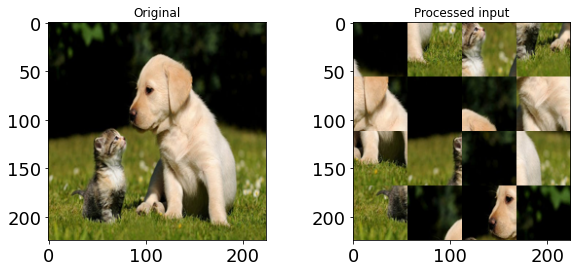

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.set_title('Original')
ax2.set_title('Processed input')
_ = ax1.imshow(img_origin)
_ = ax2.imshow(im)

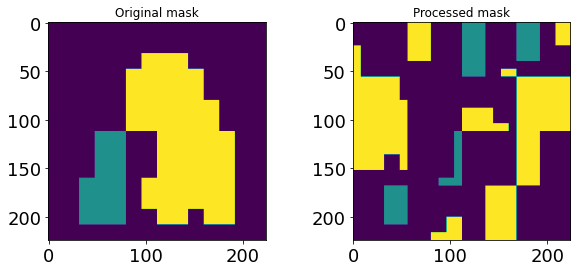

In [52]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.set_title('Original mask')
ax2.set_title('Processed mask')
_ = ax1.imshow(mask_full_keep_origin)
_ = ax2.imshow(mask_full_keep)

In [53]:
# def _attn_map(x, im):

logits, att_mat, hidden_states_layers  = model(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
att_mat.shape
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1) # [n_layer, n_tokens, n_tokens]=[12, 197, 197]
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1)) # [n_tokens, n_tokens]=[197, 197]
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# print('aug_att_mat.size: ', aug_att_mat.size())

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())

joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1] # [n_tokens, n_tokens]
grid_size = int(np.sqrt(aug_att_mat.size(-1))) # grid_size
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy() # attentions from cls_token with patch token
mask = mask / mask.max() # [im_w, im_h, 1]
mask = Image.fromarray(mask)
print('mask.size: ', mask.size)
# mask = mask / mask.max()
mask = mask.resize(im.size) # [im_w, im_h, 1]
# result = (mask * im).astype("uint8")
# result = cv2.cvtColor((mask*255.0).astype("uint8"),cv2.COLOR_GRAY2RGB)
result = (np.asarray(mask)[..., None] * np.asarray(im)).astype("uint8")

mask.size:  (14, 14)


Prediction Label and Attention Map!

0.53063 : Labrador_retriever
0.29608 : golden_retriever
0.03764 : kuvasz
0.02066 : Great_Pyrenees
0.01665 : clumber, clumber_spaniel


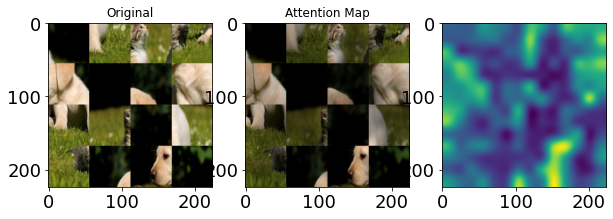

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))

ax1.set_title('Original')
ax2.set_title('Attention image')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)
_ = ax3.imshow(np.asarray(mask))

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

# <font color="blue">Visualize feature map</font>

In [44]:
from sklearn.manifold import TSNE

In [55]:
tsne_feature_layers = []
for hidden_states in hidden_states_layers:
#   input_tsne = torch.cat([hidden_states[0], cls_head_weight])
    input_tsne = hidden_states[0]
    tsne_feature = TSNE(n_components=2, perplexity=30.0, n_iter=1000, n_jobs=8, verbose=2).fit_transform(input_tsne.detach().numpy())
    tsne_feature_layers.append(tsne_feature)

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 197 samples in 0.000s...
[t-SNE] Computed neighbors for 197 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 11.416066
[t-SNE] Computed conditional probabilities in 0.076s
[t-SNE] Iteration 50: error = 60.2294235, gradient norm = 0.5522870 (50 iterations in 0.300s)
[t-SNE] Iteration 100: error = 62.6786919, gradient norm = 0.5472673 (50 iterations in 0.211s)
[t-SNE] Iteration 150: error = 62.8056183, gradient norm = 0.5151172 (50 iterations in 0.582s)
[t-SNE] Iteration 200: error = 61.7741585, gradient norm = 0.5227967 (50 iterations in 0.111s)
[t-SNE] Iteration 250: error = 62.8644714, gradient norm = 0.4501142 (50 iterations in 0.065s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.864471
[t-SNE] Iteration 300: error = 0.8841493, gradient norm = 0.0092624 (50 iterations in 0.093s)
[t-SNE] Iteration 350: error = 0.6773843, gradient norm = 0.0028951 

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 13.710005
[t-SNE] Computed conditional probabilities in 0.058s
[t-SNE] Iteration 50: error = 61.9963531, gradient norm = 0.5443487 (50 iterations in 0.251s)
[t-SNE] Iteration 100: error = 62.7413940, gradient norm = 0.4542962 (50 iterations in 0.184s)
[t-SNE] Iteration 150: error = 62.2339859, gradient norm = 0.5155509 (50 iterations in 0.317s)
[t-SNE] Iteration 200: error = 63.3039169, gradient norm = 0.5082440 (50 iterations in 0.221s)
[t-SNE] Iteration 250: error = 62.7727318, gradient norm = 0.5029452 (50 iterations in 0.197s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.772732
[t-SNE] Iteration 300: error = 0.6826585, gradient norm = 0.0075025 (50 iterations in 0.221s)
[t-SNE] Iteration 350: error = 0.5663863, gradient norm = 0.0038317 (50 iterations in 0.125s)
[t-SNE] Iteration 400: error = 0.5372625, gradient norm = 0.0005951 (50 iterations in 0.272s)
[t-SNE] Iteration 4

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 17.144644
[t-SNE] Computed conditional probabilities in 0.070s
[t-SNE] Iteration 50: error = 60.8327332, gradient norm = 0.5148517 (50 iterations in 0.381s)
[t-SNE] Iteration 100: error = 63.2924843, gradient norm = 0.4571394 (50 iterations in 0.271s)
[t-SNE] Iteration 150: error = 61.0435600, gradient norm = 0.5068926 (50 iterations in 0.219s)
[t-SNE] Iteration 200: error = 61.0437088, gradient norm = 0.5498798 (50 iterations in 0.292s)
[t-SNE] Iteration 250: error = 63.0410538, gradient norm = 0.5099355 (50 iterations in 0.486s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.041054
[t-SNE] Iteration 300: error = 0.7148257, gradient norm = 0.0056075 (50 iterations in 0.209s)
[t-SNE] Iteration 350: error = 0.5694654, gradient norm = 0.0030040 (50 iterations in 0.369s)
[t-SNE] Iteration 400: error = 0.4478379, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 19.329410
[t-SNE] Computed conditional probabilities in 0.067s
[t-SNE] Iteration 50: error = 61.4336357, gradient norm = 0.5191523 (50 iterations in 0.394s)
[t-SNE] Iteration 100: error = 61.7860794, gradient norm = 0.5235510 (50 iterations in 0.343s)
[t-SNE] Iteration 150: error = 62.8811913, gradient norm = 0.5575924 (50 iterations in 0.087s)
[t-SNE] Iteration 200: error = 61.8156738, gradient norm = 0.5359919 (50 iterations in 0.090s)
[t-SNE] Iteration 250: error = 60.7838593, gradient norm = 0.5352159 (50 iterations in 0.080s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.783859
[t-SNE] Iteration 300: error = 0.7495202, gradient norm = 0.0063252 (50 iterations in 0.278s)
[t-SNE] Iteration 350: error = 0.5527180, gradient norm = 0.0037536 (50 iterations in 0.381s)
[t-SNE] Iteration 400: error = 0.5144320, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 21.672148
[t-SNE] Computed conditional probabilities in 0.074s
[t-SNE] Iteration 50: error = 62.5441284, gradient norm = 0.5499369 (50 iterations in 0.291s)
[t-SNE] Iteration 100: error = 62.4252090, gradient norm = 0.5110875 (50 iterations in 0.248s)
[t-SNE] Iteration 150: error = 61.9662056, gradient norm = 0.5236382 (50 iterations in 0.113s)
[t-SNE] Iteration 200: error = 60.7473297, gradient norm = 0.5500675 (50 iterations in 0.046s)
[t-SNE] Iteration 250: error = 62.4438972, gradient norm = 0.4921762 (50 iterations in 0.063s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.443897
[t-SNE] Iteration 300: error = 0.5376495, gradient norm = 0.0043793 (50 iterations in 0.084s)
[t-SNE] Iteration 350: error = 0.4285207, gradient norm = 0.0033136 (50 iterations in 0.125s)
[t-SNE] Iteration 400: error = 0.4138275, gradient norm = 0.0017752 (50 iterations in 0.119s)
[t-SNE] Iteration 4

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 24.460140
[t-SNE] Computed conditional probabilities in 0.050s
[t-SNE] Iteration 50: error = 59.1143608, gradient norm = 0.5169364 (50 iterations in 0.318s)
[t-SNE] Iteration 100: error = 60.3976593, gradient norm = 0.5105201 (50 iterations in 0.109s)
[t-SNE] Iteration 150: error = 59.2750854, gradient norm = 0.5285033 (50 iterations in 0.144s)
[t-SNE] Iteration 200: error = 59.5601311, gradient norm = 0.5440614 (50 iterations in 0.144s)
[t-SNE] Iteration 250: error = 59.2928925, gradient norm = 0.5279463 (50 iterations in 0.394s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.292892
[t-SNE] Iteration 300: error = 0.5891889, gradient norm = 0.0039021 (50 iterations in 0.198s)
[t-SNE] Iteration 350: error = 0.4324083, gradient norm = 0.0037934 (50 iterations in 0.132s)
[t-SNE] Iteration 400: error = 0.3515508, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 28.065073
[t-SNE] Computed conditional probabilities in 0.058s
[t-SNE] Iteration 50: error = 58.0532265, gradient norm = 0.5497632 (50 iterations in 0.466s)
[t-SNE] Iteration 100: error = 58.8314400, gradient norm = 0.5481996 (50 iterations in 0.186s)
[t-SNE] Iteration 150: error = 60.2162094, gradient norm = 0.5230716 (50 iterations in 0.433s)
[t-SNE] Iteration 200: error = 60.0896950, gradient norm = 0.5251928 (50 iterations in 0.233s)
[t-SNE] Iteration 250: error = 59.9945412, gradient norm = 0.5373304 (50 iterations in 0.126s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.994541
[t-SNE] Iteration 300: error = 0.4180685, gradient norm = 0.0073327 (50 iterations in 0.085s)
[t-SNE] Iteration 350: error = 0.3328238, gradient norm = 0.0018132 (50 iterations in 0.129s)
[t-SNE] Iteration 400: error = 0.3223881, gradient norm = 0.0030001 (50 iterations in 0.124s)
[t-SNE] Iteration 4

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.191s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 30.951059
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 60.1475143, gradient norm = 0.4992083 (50 iterations in 0.155s)
[t-SNE] Iteration 100: error = 57.0154457, gradient norm = 0.5663525 (50 iterations in 0.347s)
[t-SNE] Iteration 150: error = 58.5404892, gradient norm = 0.5301127 (50 iterations in 0.321s)
[t-SNE] Iteration 200: error = 58.8175316, gradient norm = 0.5256029 (50 iterations in 0.092s)
[t-SNE] Iteration 250: error = 58.8901787, gradient norm = 0.5220150 (50 iterations in 0.081s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.890179
[t-SNE] Iteration 300: error = 0.3788328, gradient norm = 0.0073624 (50 iterations in 0.117s)
[t-SNE] Iteration 350: error = 0.2994494, gradient norm = 0.0009981 (50 iterations in 0.103s)
[t-SNE] Iteration 400: error = 0.2928400, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 34.074926
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 59.5632210, gradient norm = 0.4784485 (50 iterations in 0.423s)
[t-SNE] Iteration 100: error = 57.7289047, gradient norm = 0.5144754 (50 iterations in 0.144s)
[t-SNE] Iteration 150: error = 56.6205368, gradient norm = 0.5371299 (50 iterations in 0.170s)
[t-SNE] Iteration 200: error = 58.4111900, gradient norm = 0.5036264 (50 iterations in 0.221s)
[t-SNE] Iteration 250: error = 58.7166443, gradient norm = 0.4916623 (50 iterations in 0.461s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.716644
[t-SNE] Iteration 300: error = 0.3419228, gradient norm = 0.0059914 (50 iterations in 0.066s)
[t-SNE] Iteration 350: error = 0.2789028, gradient norm = 0.0009039 (50 iterations in 0.086s)
[t-SNE] Iteration 400: error = 0.2694431, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 38.838121
[t-SNE] Computed conditional probabilities in 0.103s
[t-SNE] Iteration 50: error = 57.5639954, gradient norm = 0.5185017 (50 iterations in 0.722s)
[t-SNE] Iteration 100: error = 57.5341377, gradient norm = 0.5300824 (50 iterations in 0.255s)
[t-SNE] Iteration 150: error = 56.4147453, gradient norm = 0.5276322 (50 iterations in 0.168s)
[t-SNE] Iteration 200: error = 57.4972382, gradient norm = 0.4990838 (50 iterations in 0.195s)
[t-SNE] Iteration 250: error = 58.3492432, gradient norm = 0.5008059 (50 iterations in 0.171s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.349243
[t-SNE] Iteration 300: error = 0.2828084, gradient norm = 0.0060309 (50 iterations in 0.080s)
[t-SNE] Iteration 350: error = 0.2630140, gradient norm = 0.0004488 (50 iterations in 0.152s)
[t-SNE] Iteration 400: error = 0.2616272, gradient norm =

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 49.075781
[t-SNE] Computed conditional probabilities in 0.083s
[t-SNE] Iteration 50: error = 58.9939499, gradient norm = 0.5176322 (50 iterations in 0.475s)
[t-SNE] Iteration 100: error = 59.3836670, gradient norm = 0.5108998 (50 iterations in 0.166s)
[t-SNE] Iteration 150: error = 58.2336311, gradient norm = 0.5367392 (50 iterations in 0.206s)
[t-SNE] Iteration 200: error = 59.9376450, gradient norm = 0.5217368 (50 iterations in 0.234s)
[t-SNE] Iteration 250: error = 58.4028435, gradient norm = 0.5121580 (50 iterations in 0.383s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.402843
[t-SNE] Iteration 300: error = 0.3661591, gradient norm = 0.0059870 (50 iterations in 0.173s)
[t-SNE] Iteration 350: error = 0.3032696, gradient norm = 0.0016146 (50 iterations in 0.179s)
[t-SNE] Iteration 400: error = 0.2982219, gradient norm = 0.0005480 (50 iterations in 0.213s)
[t-SNE] Iteration 4

/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/miruware/anaconda3/envs/defor_detr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 51.389434
[t-SNE] Computed conditional probabilities in 0.068s
[t-SNE] Iteration 50: error = 59.8423691, gradient norm = 0.5187454 (50 iterations in 0.085s)
[t-SNE] Iteration 100: error = 58.4760437, gradient norm = 0.5379295 (50 iterations in 0.049s)
[t-SNE] Iteration 150: error = 56.8205833, gradient norm = 0.5544039 (50 iterations in 0.048s)
[t-SNE] Iteration 200: error = 58.9174576, gradient norm = 0.5444651 (50 iterations in 0.070s)
[t-SNE] Iteration 250: error = 59.9182053, gradient norm = 0.5135581 (50 iterations in 0.055s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.918205
[t-SNE] Iteration 300: error = 0.3961521, gradient norm = 0.0064507 (50 iterations in 0.152s)
[t-SNE] Iteration 350: error = 0.3362741, gradient norm = 0.0007488 (50 iterations in 0.142s)
[t-SNE] Iteration 400: error = 0.3290117, gradient norm =

# <font color="blue">Hand segmentation process</font>

In [56]:
# segmentation_mask = targets['masks'].type(torch.float)
mask_to_idx = []
num_object = len(np.unique(mask_full_keep)) - 1
mask_resize = np.zeros((14,14))
for i in range(14):
    for j in range(14):
#         print(i*16,(i+1)*16, j*16,(j+1)*16)
        unique_m, count_m = np.unique(mask_full_keep[i*16:(i+1)*16, j*16:(j+1)*16], return_counts=True)
        mask_resize[i, j] = unique_m[np.argmax(count_m)]
#         print(unique_m, count_m, unique_m[np.argmax(count_m)])

mask_resize = mask_resize.reshape(-1).astype(np.int64)
# print(mask_resize.max(), mask_resize.min())
for idx_object in range(num_object):
    m_instance = np.argwhere(mask_resize == idx_object+1)
    mask_to_idx.append(m_instance)
total_mask = np.where(mask_resize >= 1)
none_object_idx = np.where(mask_resize == 0)
mask_to_idx.append(none_object_idx)

Text(0.5, 0, 'Attention score last layer')

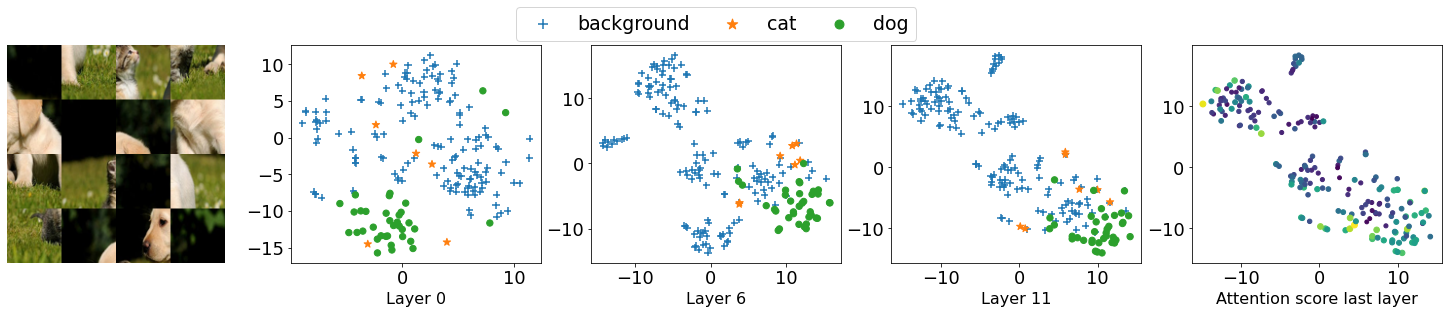

In [57]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-1.5, 1.02, 1.6, .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_dog_cat_shuffle_2.png", bbox_inches='tight', pad_inches=0)

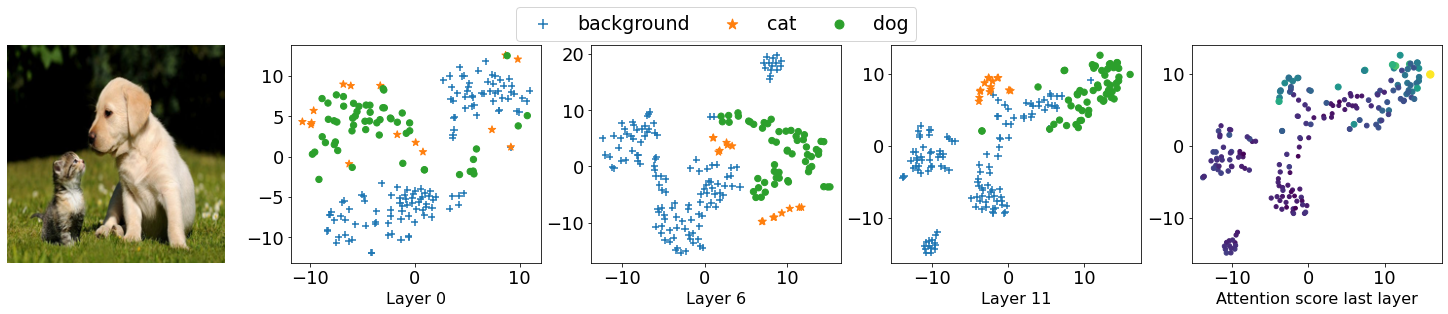

In [47]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-1.5, 1.02, 1.6, .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_dog_cat.png", bbox_inches='tight', pad_inches=0)

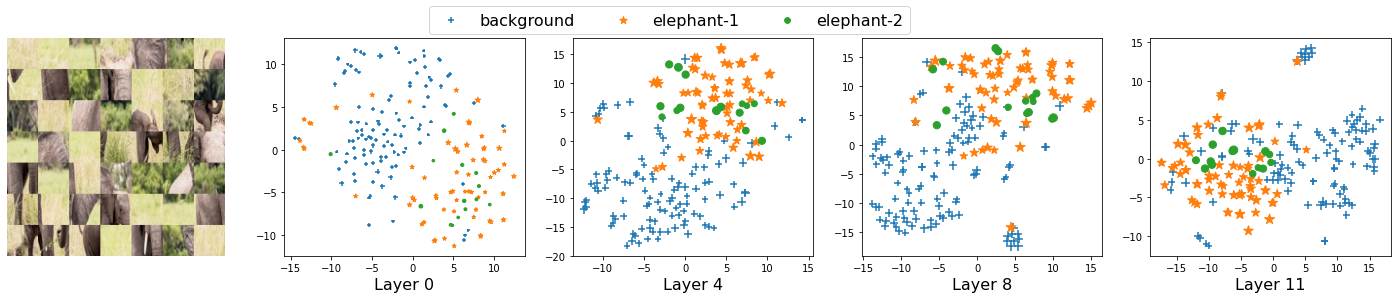

In [362]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['elephant-1', "elephant-2", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3, 1.02, 2., .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_2_elephant_shuffle.png", bbox_inches='tight', pad_inches=0)

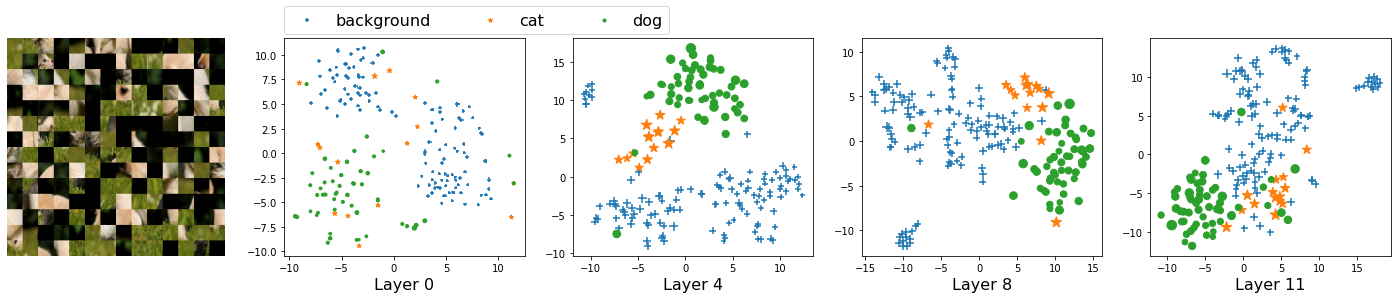

In [320]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3, 1.02, 2., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_dog_cat_shuffle_2.png", bbox_inches='tight', pad_inches=0)

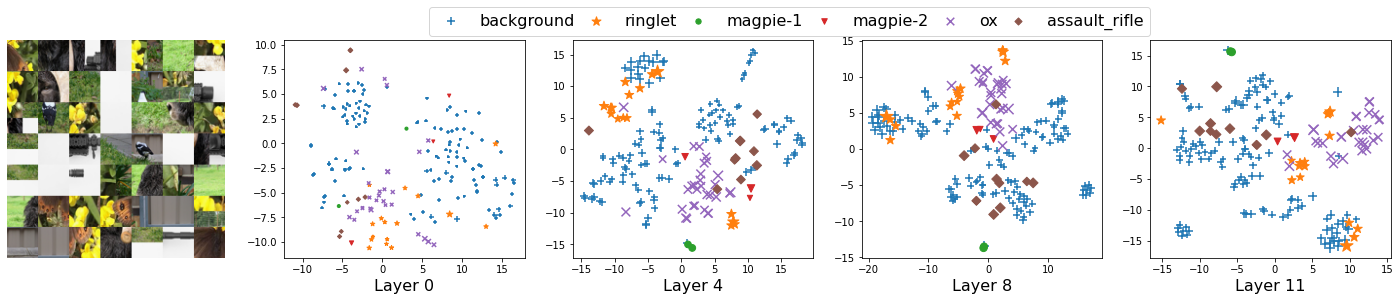

In [338]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
#     lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3., 1.02, 3, .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_multi_objects_shuffle.png", bbox_inches='tight', pad_inches=0)

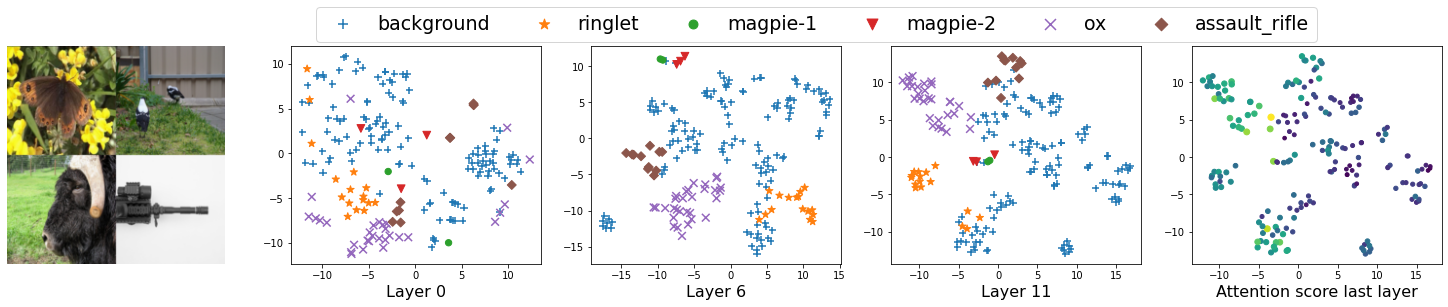

In [91]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
    lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
#     lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-2.3, 1.02, 4, .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_multi_objects.png", bbox_inches='tight', pad_inches=0)